It's interesting to note that in deep learning, the evolution of architecture and techniques is very rapid, but certain aspects can remain in bits of code for years without really knowing if they're really necessary. Most of the time, we take it for granted that they have been optimized and should not be bothered with.

One such aspect is the *input normalization* applied to the input of most convolutional neural networks (CNNs) used to process visual images. This is especially true since we often use networks in the community that are pre-trained on images normalized to given values, such as VGG or ResNET. If you ask Github's Copilot, it says that:

>    Image normalization in convolutional neural networks (CNNs) has several beneficial effects:
>    1- Improved convergence: Normalization helps to stabilize and speed up the learning process by ensuring that pixel values are in a similar range, thus facilitating optimization.
>    2- Reduced sensitivity to scale variations: Normalizing images reduces the model's sensitivity to scale variations in pixel values, which can improve model robustness.
>    3- Prevention of neuron saturation: Unnormalized pixel values can lead to neuron saturation, which slows down learning. Normalization helps prevent this problem.
>    4- Improved performance: In general, image normalization can lead to better model performance in terms of accuracy and generalization.

**I'm interested here in whether these networks remain effective when we change the input normalization.** In fact, since the weights of the first convolutional layer are learned, and since convolution kernels can be multiplied by arbitrary values thanks to the bias in the convolutions, it makes no sense to normalize to a certain value, but simply to normalize. This is even more obvious when these values are given with 3-digit precision! I propose here to show quantitatively that this is the case, first for a *historical* network [LeNet](https://en.wikipedia.org/wiki/LeNet) applied to the MNIST challenge, and then for [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) applied to ImageNet.


<!-- TEASER_END -->

Let's first initialize the notebook:

In [3]:
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os

import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)

In [4]:
%pip install -Uq -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
%mkdir -p data

## The MNIST challenge and the *French Touche* 

First, let's explore the *LeNet* network  (Lecun, Y.; Bottou, L.; Bengio, Y.; Haffner, P. (1998). "Gradient-based learning applied to document recognition" (PDF). Proceedings of the IEEE. 86 (11): 2278–2324. doi:10.1109/5.726791. S2CID 14542261), whose objective is to categorize images of written digits, one of the first great successes of Multilayer neural networks. For this one, we're going to use the classic implementation, as proposed in the PyTorch library example series. 



The cell below allows you to do everything: first load the libraries, then define the neural network, and finally define the learning and testing procedures that are applied to the database. The output accuracy value corresponds to the percentage of letters that are correctly classified.

In this cell, we'll isolate the two parameters used to set the mean and standard deviation applied to the normalization function, which we'll be manipulating in the course of this book.

In [6]:
# adapted from https://raw.githubusercontent.com/pytorch/examples/refs/heads/main/mnist/main.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

epochs = 15

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % log_interval  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


def main(mean, std, weight_init=None, bias_init=None, epochs=epochs, log_interval=100, verbose=False):
    # Training settings
    torch.manual_seed(1998) # FOOTIX rules !
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if torch.cuda.is_available():
        device = torch.device("cuda")
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    if mean is None:
        transform = transforms.ToTensor()
    else:
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
            ])
    dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)

    dataset2 = datasets.MNIST('data', train=False,
                       transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)

    if not bias_init is None:
        model.conv1.bias.data *= bias_init
    if not weight_init is None:
        model.conv1.weight.data *= weight_init

    
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    scheduler = ReduceLROnPlateau(optimizer, 'max')
    for epoch in range(1, epochs+1):
        train(model, device, train_loader, optimizer, epoch, log_interval=log_interval, verbose=verbose)
        accuracy = test(model, device, test_loader, verbose=verbose)
        scheduler.step(accuracy)

    if verbose: print(f'The std of weight and bias in the first convolutional layer is {model.conv1.weight.std().item():.4f} and  {model.conv1.bias.std().item():.4f}')
    return accuracy


(You will notice that I made minor changes, such as using the `ReduceLROnPlateau` scheduler instead of `StepLR`. In practice, this only changed the values I could test - run the notebook with enough epochs and the other scheduler to see for yourself.)

Now that we've defined the entire protocol, we can test it in its most classic form, as delivered in the original code, with 3-digit precision (!):

In [7]:
accuracy = main(mean=0.1307, std=0.3081, verbose=True)
print(f'{accuracy=:.4f}')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304859
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.289305
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.213311
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.308440
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.147784
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.176286
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.155225
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.146125
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.139085
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.113915

Test set: Average loss: 0.0500, Accuracy: 9830/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.066308
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.158526
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.119711
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.136787
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.025995
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.091009
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.082308
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.030041
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.181695
T

For image normalization in LeNet  the standard values used are for ImageNet training:

* `mean=0.1307`, 
* `std=0.3081`

These exact same numbers were first introduced in that code on [Jan 17, 2017](https://github.com/pytorch/examples/commit/32c7386aef93737926069ee284d827f8e954e086) and these exact values have not changed since (up to the 3rd digit).

What is less known is that they may be retrieved from te datasets' statistics:

In [51]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def compute_dataset_stats(dataset, batch_size=256, num_workers=4):
    """
    Calculate the channel-wise mean and standard deviation of a data set
    
    Args:
        dataset: the dataset to compute the statistics from
        batch_size: Batch size for loading data
        num_workers: Number of worker processes to load data
    
    Returns:
        Means: Means per channel
        stds: Channel-wise standard deviations
    """

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )
    
    # Initialize variables for computing means
    mean = torch.zeros(3)
    mean_squared = torch.zeros(3)
    total_batches = 0
    
    print("Computing mean and standard deviation...")
    # First pass: compute mean
    for images, _ in tqdm(loader):
        batch_samples = images.size(0)
        # images = images.view(batch_samples, images.size(1), -1)
        mean_ = images.mean(axis=(0, -2, -1))
        mean += mean_
        mean_squared += ((images - mean_)**2).mean(axis=(0, -2, -1))
        total_batches += 1
    
    mean = mean / total_batches
    std = torch.sqrt(mean_squared / total_batches)
    
    return mean, std


dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
means, stds = compute_dataset_stats(dataset)

print("MNIST stats on the train set:")
print(f"Mean: {means[0]:.4f}")
print(f"Std: {stds[0]:.4f}")


dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
means, stds = compute_dataset_stats(dataset)

print("MNIST stats on the test set:")
print(f"Mean: {means[0]:.4f}")
print(f"Std: {stds[0]:.4f}")

Computing mean and standard deviation...


100%|██████████| 235/235 [00:02<00:00, 81.11it/s] 


MNIST stats on the train set:
Mean: 0.1306
Std: 0.3079
Computing mean and standard deviation...


100%|██████████| 40/40 [00:02<00:00, 18.04it/s]

MNIST stats on the test set:
Mean: 0.1332
Std: 0.3110


The core idea here is that we train a network for given values so that whenever we feed in new input values, such as from the validation set, the batch will have similar first-order statistics. But is this hypothesis really important given the architecture of the network? 

One advantage of our code is that we can now manipulate these two values, to see if starting from a different tuple of numbers, we obtain an accuracy value that is different.



Let's first see what happens without normalization:

In [9]:
accuracy = main(mean=None, std=None)
print(f'{accuracy=:.4f}')

accuracy=0.9926


Pretty much the same... but slightly better.

What if we use standard numbers?

In [10]:
accuracy = main(mean=0., std=1.)
print(f'{accuracy=:.4f}')

accuracy=0.9926


The result seems similar, but it's not enough to demonstrate that the mean and standard deviation have no effect on learning.

### computing accuracy on a regular grid of values

I'm now going to push the boat out further, using a library that allows me to test several values and thus optimize the parameters. If the mean and deviation are so important, we'll converge on a fixed set of values, whereas if they're less important, the values can be quite scattered. In particular, this will allow us to choose an arbitrary value, such as a mean of 0 and a standard deviation of 1, better known as *normal* normalization.

In [11]:
model = 'LeNet'
epochs = 30 # a bit more than the original example which had 15 epochs
N_scan = 15

means = np.linspace(-2, 3., N_scan, endpoint=True)
stds = np.geomspace(0.02, 2., N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}.npy'
# %rm {path_save_numpy}
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean=mean, std=std, epochs=epochs)
    np.save(path_save_numpy, accuracy)
else:
    print(f'Loading {path_save_numpy}')
    accuracy = np.load(path_save_numpy)    

Loading numpy-LeNet.npy


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_61960/4244923449.py:2: UserWarning: The following kwargs were not used by contour: 'n'
  CS = ax.contourf(means, stds, accuracy, n=20, cmap='viridis')


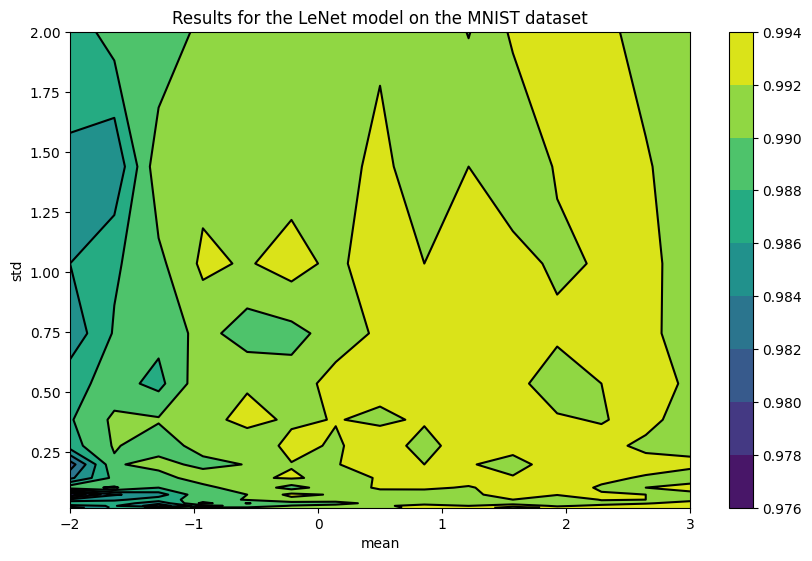

In [12]:
fig, ax = plt.subplots(figsize=figsize)
CS = ax.contourf(means, stds, accuracy, n=20, cmap='viridis')
CS2 = ax.contour(CS, levels=CS.levels, colors='k')
fig.colorbar(CS, ax=ax, extendfrac=0)
ax.set_title('Results for the LeNet model on the MNIST dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

One is most certainly interested by the best value:

In [13]:
mean_max, std_max = np.unravel_index(np.argmax(accuracy), accuracy.shape)
print(f'Optimal value at indicies {mean_max, std_max}, with accuracy {accuracy[mean_max, std_max]:.4f}')

Optimal value at indicies (12, 7), with accuracy 0.9936


In [14]:
print(f'Optimal value: of mean={means[mean_max]:.4f}, std={stds[std_max]:.4f}')

Optimal value: of mean=2.2857, std=0.2000


Or by the barycenter of the accuracy map:

In [15]:
print(f'Center of gravity: {np.sum(means*accuracy)/np.sum(accuracy):.4f}, {np.sum(stds*accuracy)/np.sum(accuracy):.4f}')

Center of gravity: 0.5026, 0.4728


There is a low variabilty of the accuracy:

In [16]:
print(f'Variabity of accuracy: {np.std(accuracy):.4f}')

Variabity of accuracy: 0.0025


Mostly driven by the worst value:

In [17]:
mean_min, std_min = np.unravel_index(np.argmin(accuracy), accuracy.shape)
accuracy_min = accuracy[mean_min, std_min]
print(f'Worst value at indicies {mean_min, std_min}, with accuracy {accuracy_min:.4f}')

Worst value at indicies (4, 0), with accuracy 0.9779


In [18]:
print(f'Worst value: of mean={means[mean_min]:.4f}, std={stds[std_min]:.4f}')

Worst value: of mean=-0.5714, std=0.0200


The variability on the plateau is very low:

In [19]:
accuracy_best95 = accuracy[accuracy >np.percentile(accuracy, .05)].flatten()
print(f'Mean of accuracy for the best 95%: {np.mean(accuracy_best95):.4f}')
print(f'Variabity of accuracy for the best 95%: {np.std(accuracy_best95):.4f}')

Mean of accuracy for the best 95%: 0.9908
Variabity of accuracy for the best 95%: 0.0023


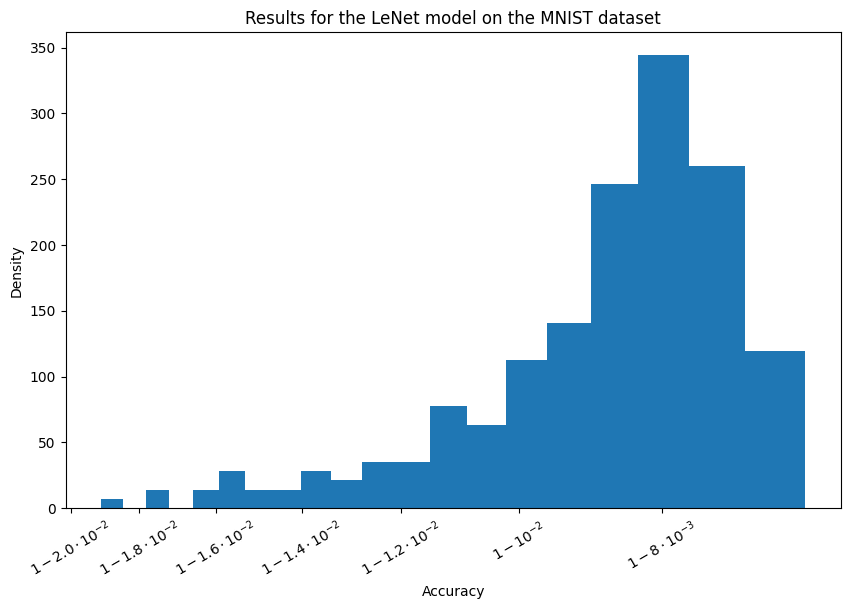

In [20]:
fig, ax = plt.subplots(figsize=figsize)
ax.hist(accuracy_best95, bins=20, density=True)
ax.set_title('Results for the LeNet model on the MNIST dataset')
ax.set_xlabel('Accuracy')
ax.set_xscale('logit')
plt.xticks(rotation=30)
ax.set_ylabel('Density')
fig;

Such that we can confidently say that we do not need a 3 digits initialization

In [22]:
accuracy = main(mean=0.5, std=0.5, verbose=False)
print(f'{accuracy=:.4f}')

accuracy=0.9916


### using optuna to search on a non-regular grid of values

I'm now going to push the boat out further, using a library that allows me to test several values and thus optimize the parameters. If the mean and deviation are so important, we'll converge on a fixed set of values, whereas if they're less important, the values can be quite scattered. In particular, this will allow us to choose an arbitrary value, such as a mean of 0 and a standard deviation of 1, better known as *normal* normalization.

In [28]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [29]:
path_save_optuna =  f'optuna-{model}.sqlite3'
print(f'-> file {path_save_optuna} exists: {os.path.isfile(path_save_optuna)}')

-> file optuna-LeNet.sqlite3 exists: True


In [30]:
n_trials = 200

In [31]:
# %rm {path_save_optuna}

In [32]:
def objective(trial):
    mean = trial.suggest_float('mean', -1, 2., log=False)
    std = trial.suggest_float('std', 0.05, 1., log=True)
    accuracy = main(mean=mean, std=std, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model)
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean': 0.1440116283993092, 'std': 0.5690034868978842}
Best value:  0.9935


/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_61960/2318167149.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
[W 2024-12-26 10:00:01,678] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


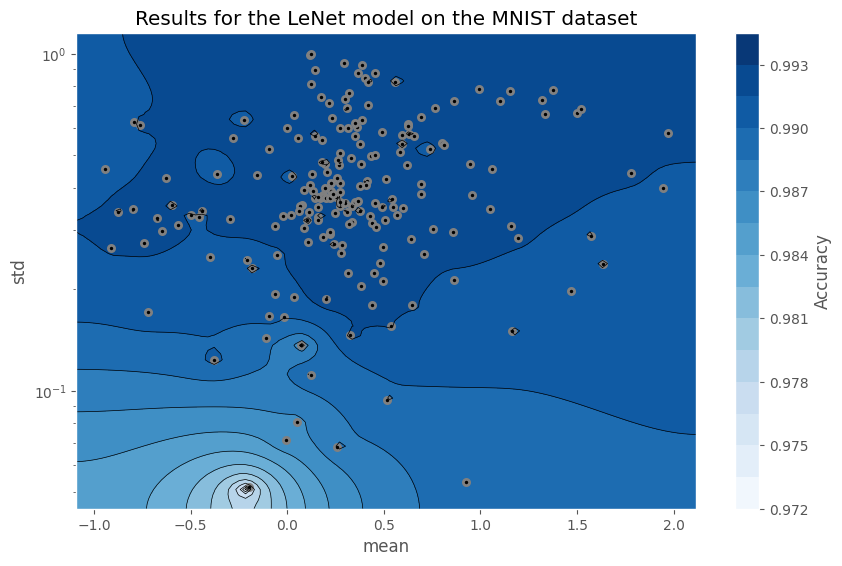

In [33]:
# https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/generated/optuna.visualization.matplotlib.contour.html
from optuna.visualization.matplotlib import plot_contour

ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
fig = plt.gcf()
ax.set_title('Results for the LeNet model on the MNIST dataset')
fig.set_size_inches(figsize[0], figsize[1])

The picture is quite similar to the one above (note the log axis for `std`).

An open question remains: why do these values matter when we have so many ways to counteract them, like setting bias values, scaling the weights, using batch normalization? 

And wait, how are the values of these parameters determined? How are the layer weights and biases initialized by default?

For [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and [nn.conv2D](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.Conv2d.html), the weights are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{\text{in\_features}}$ for the linear layer and $k = \frac{1}{C_\text{in} * \prod_{i=0}^{1}\text{kernel\_size}[i]}$.

This is done by [Glorot initialization](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) :


In [34]:
conv1 = nn.Conv2d(1, 32, 3, 1)
print(f'The mean of weight and bias in the first convolutional layer is {conv1.weight.mean().item():.4f} and  {conv1.bias.mean().item():.4f}')
print(f'The std of weight and bias in the first convolutional layer is {conv1.weight.std().item():.4f} and  {conv1.bias.std().item():.4f}')
print(f' k= {1/3/3/1:.4f}, sqrt(k) = {np.sqrt(1/3/3/1):.4f}$')


The mean of weight and bias in the first convolutional layer is 0.0309 and  -0.0433
The std of weight and bias in the first convolutional layer is 0.1853 and  0.2009
 k= 0.1111, sqrt(k) = 0.3333$


### using optuna to search for another initialization point


Let's see if for a given value for which we know the accuracy was worst (`mean=mean_min` and `std=std_min`), we can optimize the bias and weight intialization to get a better value, like that of the 95% best values obtained.


In [35]:
def objective(trial):
    weight_init = trial.suggest_float('weight_init', 0.05, 20., log=True)
    bias_init = trial.suggest_float('bias_init', 0.05, 20., log=True)
    accuracy = main(mean=-1, std=0.1, weight_init=weight_init, bias_init=bias_init, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-init_WB')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'weight_init': 0.307155100974441, 'bias_init': 5.5455929037599185}
Best value:  0.9941


So it's a clear **yes** as we move that value above the range of 95% values computed on the range above.

In [36]:
print(f'Mean of accuracy for the best 95%: {np.mean(accuracy_best95):.4f}')
print(f'Variabity of accuracy for the best 95%: {np.std(accuracy_best95):.4f}')

Mean of accuracy for the best 95%: 0.9908
Variabity of accuracy for the best 95%: 0.0023


## The ImageNet challenge and *residual networks* 

Second, let's tackle a real world problem: image classification with 1 million images and 1000 labels. For this we will use the well-known Resnet model defined in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) as it givves a nice balance between simplicity and performance. In general, [Residual neural networks](https://en.wikipedia.org/wiki/Residual_neural_network) are widely used architectures for feed-forward networks appliead to image categorization. 


https://pytorch.org/hub/pytorch_vision_resnet/

In [43]:
import torch
from torchvision.models import ResNet18_Weights

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT)
# or any of these variants 'resnet34', 'resnet50', 'resnet101', 'resnet152',
model

Using cache found in /Users/laurentperrinet/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

For image normalization in ResNet (and many other computer vision models), the standard values used are for ImageNet training:

* Mean: `[0.485, 0.456, 0.406]` (for R,G,B channels respectively)
* Std: `[0.229, 0.224, 0.225]`

And which may be retrieved from te datasets' statistics:

In [ ]:
import os
os.homedir()

In [53]:
DATADIR = '../Deep_learning/data/Imagenet_redux'
DATADIR = '/Volumes/SSD1TO/Deep_learning/data/Imagenet_full'
DATADIR = '/home/laurent/app54_nextcloud/2024_archives/2024_science/Deep_learning/data/Imagenet_full'


In [54]:
# Replace with your ImageNet data path
# Only transform to tensor and divide by 255
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()  # Scales data to [0,1]
])

for type in ['train', 'test']:
    dataset = torchvision.datasets.ImageFolder(f"{DATADIR}/{type}", transform=transform)
    means, stds = compute_dataset_stats(dataset)
    print(f"\nImageNet stats on the {type} set:")
    print(f"Means: {[round(m, 3) for m in means]}")
    print(f"Stds: {[round(s, 3) for s in stds]}")


Computing mean and standard deviation...


  0%|          | 0/5005 [00:14<?, ?it/s]


RuntimeError: The size of tensor a (224) must match the size of tensor b (3) at non-singleton dimension 3


These values have become standard practice even when training on other datasets, although technically you could calculate and use dataset-specific normalization values.

These normalization values were first calculated in the early days of the rise of deep learning in computer vision, around 2012-2015. They come from calculating the mean and standard deviation per channel across the entire ImageNet training set of 1.2 million images, with the idea that each incoming batch should have the same first-order statistics. These values were widely adopted after the success of AlexNet (2012) and subsequent models such as VGG (2014) and ResNet (2015) on ImageNet.

These values have since become a de facto standard in computer vision, with frameworks like PyTorch and TensorFlow using them as default values in their model zoos and tutorials. They're particularly associated with models trained on ImageNet, though they're also often used when training on other datasets due to their proven effectiveness in practice.

### Training ResNet

The cell below allows you to do everything: first load the libraries, then define the neural network, and finally define the learning and testing procedures to be applied to the database. The output accuracy value corresponds to the percentage of correctly classified images. For simplicity, we use pre-trained weights and the retraining protocol used in [Jean-Nicolas Jérémie, Laurent U Perrinet (2023). Ultra-Fast Image Categorization in Biology and in Neural Models](https://laurentperrinet.github.io/publication/jeremie-23-ultra-fast-cat/) and available in the following code [UltraFastCat.ipynb](https://nbviewer.org/github/JNJER/2022-03_UltraFastCat/blob/main/UltraFastCat.ipynb)

In this cell, we'll isolate the two parameters used to set the mean and standard deviation applied to the normalization function we'll be manipulating throughout this book. Since we have color images, that is, 3 channels, this means that we are manipulating 6 variables.

In [2]:
epochs = 1

def train(model, device, train_loader, criterion, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % log_interval  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    if verbose:
        print('\nTest set: Av Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

def main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs, log_interval=100, verbose=False):
    # Training settings
    torch.manual_seed(1998) # FOOTIX rules !
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if torch.cuda.is_available():
        device = torch.device("cuda")
        cuda_kwargs = {'num_workers': 1,
                    #    'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((mean_R, mean_G, mean_B), (std_R, std_G, std_B))
        ])
    
    train_loader = torch.utils.data.DataLoader(datasets.ImageFolder(DATADIR + '/train', transform=transform), **train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.ImageFolder(DATADIR + '/val', transform=transform), **test_kwargs)

    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT, verbose=False)
    model = model.to(device)

    # model.conv1.bias.data -= mean
    # model.conv1.weight.data /= std

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(1, epochs):
        train(model, device, train_loader, criterion, optimizer, epoch, log_interval=log_interval, verbose=verbose)
        scheduler.step()

    accuracy = test(model, device, test_loader, verbose=verbose)
    return accuracy


Now that we've defined the entire protocol, we can test it in its most classic form, as delivered in the original code by 6 numbers with 3 digits precision:

In [ ]:
accuracy = main(0.485, 0.456, 0.406, 0.229, 0.224, 0.225)
print(f'{accuracy=:.4f}')

What does it yield with normal parameters?

In [ ]:
accuracy = main(0., 0., 0., 1., 1., 1.)
print(f'{accuracy=:.4f}')

### using optuna to search for another initialization point


Let's scan the parameters:

In [36]:
model = 'ResNet'

In [37]:
N_scan = 15
means = np.linspace(-3, 3, N_scan, endpoint=True)
stds = np.geomspace(0.05, 1., N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}.npy'
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean, mean, mean, std, std, std, epochs=epochs)

    np.save(path_save_numpy, accuracy)
else:
    accuracy = np.load(path_save_numpy)

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
pcm = ax.contourf(means, stds, accuracy, cmap='hot')
fig.colorbar(pcm, ax=ax)
ax.set_title('Results for the ResNet model on the ImageNet dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

Let's zoom around the central region

In [ ]:
N_scan = 15
means = np.linspace(-.5, 1.5, N_scan, endpoint=True)
stds = np.geomspace(0.20, 0.6, N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}-zoom.npy'
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean, mean, mean, std, std, std, epochs=epochs)

    np.save(path_save_numpy, accuracy)
else:
    accuracy = np.load(path_save_numpy)

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
pcm = ax.contourf(means, stds, accuracy, cmap='hot')
fig.colorbar(pcm, ax=ax)
ax.set_title('Results for the ResNet model on the ImageNet dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

### using optuna to search for another initialization point


And now with optuna:

In [39]:
path_save_optuna =  f'optuna-{model}.sqlite3'

In [40]:
# %rm {path_save_optuna}

In [41]:
def objective(trial):
    mean = trial.suggest_float('mean', -.5, 1.5, log=False)
    std = trial.suggest_float('std', 0.20, 0.6, log=True)
    accuracy = main(mean, mean, mean, std, std, std, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model)
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

Exception ignored in: Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
<function _MultiProcessingDataLoaderIter.__del__ at 0x1384877e0>
Traceback (most recent call last):
  File "/Users/laurentperrinet/sdrive_cnrs/hot_from_git/2024-12-09-normalizing-images-in-convolutional-neural-networks/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_pickle.UnpicklingError: pickle data was truncated
    self._shutdown_workers()
  File "/Users/laurentperrinet/s

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
path_save_optuna, len(study.get_trials())

In [42]:
study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)

In [ ]:
# https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/generated/optuna.visualization.matplotlib.contour.html
from optuna.visualization.matplotlib import plot_contour

ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
ax.set_title('Results for the ResNet model on the ImageNet dataset')
fig = plt.gcf()
fig.set_size_inches(figsize[0], figsize[1])

### Appendix : looking for optimal values in RGB space

We can further explore the 6-dimensional space:


In [ ]:
def objective(trial):
    mean_R = trial.suggest_float('mean_R', -1, 2., log=False)
    mean_G = trial.suggest_float('mean_G', -1, 2., log=False)
    mean_B = trial.suggest_float('mean_B', -1, 2., log=False)
    std_R = trial.suggest_float('std_R', 0.05, 1., log=True)
    std_G = trial.suggest_float('std_G', 0.05, 1., log=True)
    std_B = trial.suggest_float('std_B', 0.05, 1., log=True)
    accuracy = main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-RGB')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

In [ ]:
def objective(trial):
    mean_R = trial.suggest_float('mean_R', .40, .60, log=False)
    mean_G = trial.suggest_float('mean_G', .40, .60, log=False)
    mean_B = trial.suggest_float('mean_B', .40, .60, log=False)
    std_R = trial.suggest_float('std_R', .15, .35, log=True)
    std_G = trial.suggest_float('std_G', .15, .35, log=True)
    std_B = trial.suggest_float('std_B', .15, .35, log=True)
    accuracy = main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-RGB_fine')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

In [ ]:
# fig, axs = plt.subplots(3, 3, figsize=figsize)
for i, c_mean in enumerate(['R', 'G', 'B']):
    for j, c_std in enumerate(['R', 'G', 'B']):
        ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
        # ax.set_title('Results for the ResNet model on the ImageNet dataset')

In [ ]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B"])
plt.gcf().set_size_inches(figsize[0]*2, figsize[1])

## some book keeping for the notebook

In [ ]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,torch  -r -g -b